# DECaLS predictions

Run the test set through the pretrained model

## Setup

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import os
import h5py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image, display

Importing project modules works best from the project root directory.

In [2]:
os.chdir('..')

import zoobot
import projcode
from projcode.data.utils import read_params
from projcode.predictions.make_predictions import decals_catalog
from projcode.predictions.view_predictions import ViewPredictions
from zoobot.shared.label_metadata import decals_pairs

In [3]:
params = read_params()

## Check the catalog file

There are also shards in `tfrecord` format, but these are bizarrely difficult to work with. Better to keep it simple.

In [4]:
dataroot = Path(params['dataroot'])
catalog_file = dataroot / 'shards/decals/test_shards/test_df.csv'

In [5]:
df = pd.read_csv(catalog_file)
df.head(3)

,Unnamed: 0,id_str,file_loc,smooth-or-featured_smooth,smooth-or-featured_featured-or-disk,smooth-or-featured_artifact,disk-edge-on_yes,disk-edge-on_no,has-spiral-arms_yes,has-spiral-arms_no,...,spiral-arm-count_1,spiral-arm-count_2,spiral-arm-count_3,spiral-arm-count_4,spiral-arm-count_more-than-4,spiral-arm-count_cant-tell,merging_none,merging_minor-disturbance,merging_major-disturbance,merging_merger
0,111075,J141907.77+042635.7,/home/colin/data/munch1tb/zoobot_data/gz_decal...,1.0,4.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
1,22533,J120551.27+242120.5,/home/colin/data/munch1tb/zoobot_data/gz_decal...,1.0,3.0,1.0,0.0,3.0,3.0,0.0,...,0.0,1.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0
2,124358,J001555.69+161458.0,/home/colin/data/munch1tb/zoobot_data/gz_decal...,4.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0


## Run predictions

Ignore all the nonsense about NUMA node. Users have been complaining about this for years, but Tensorflow still does it.

In [6]:
# save_loc = dataroot / 'results/predictions/decals.hdf5'
# %time decals_catalog(params, save_loc)

## View predictions

In [9]:
save_loc = dataroot / 'results/predictions/decals.hdf5'
vp = ViewPredictions(save_loc)
vp.make_prediction_summaries()

In [10]:
vp.results.head(2)

,file_loc,smooth-or-featured_smooth,smooth-or-featured_featured-or-disk,smooth-or-featured_artifact,disk-edge-on_yes,disk-edge-on_no,has-spiral-arms_yes,has-spiral-arms_no,bar_strong,bar_weak,...,spiral-arm-count_1,spiral-arm-count_2,spiral-arm-count_3,spiral-arm-count_4,spiral-arm-count_more-than-4,spiral-arm-count_cant-tell,merging_none,merging_minor-disturbance,merging_major-disturbance,merging_merger
0,/home/colin/data/munch1tb/zoobot_data/gz_decal...,24.585224,47.126320,2.547081,37.434212,2.384364,6.699317,4.103290,1.479639,5.054061,...,1.128513,9.593546,1.531305,2.105283,1.051178,48.488930,75.635941,6.258410,1.058971,1.219766
1,/home/colin/data/munch1tb/zoobot_data/gz_decal...,3.121219,43.051598,1.741715,1.676396,90.948959,35.482941,1.227375,1.143801,5.037024,...,1.000283,1.206696,1.258230,1.271014,1.000010,3.857238,40.318962,9.000361,2.562151,1.091530


Look at predictions for a single image, answers sorted by probability:

In [11]:
gal = vp.results.iloc[2000]

predictions = vp.summary_dict(gal)
for question in decals_pairs:
    output = f"{question}:"
    for k, v in predictions[question]:
#         print(k, v)
        output += f" {k} ({v:.2f}),"
    print(output[:-1])

smooth-or-featured: featured-or-disk (0.89), smooth (0.08), artifact (0.03)
disk-edge-on: no (0.93), yes (0.07)
has-spiral-arms: yes (0.95), no (0.05)
bar: weak (0.44), no (0.41), strong (0.16)
bulge-size: moderate (0.62), small (0.27), large (0.08), none (0.02), dominant (0.01)
how-rounded: in-between (0.57), cigar-shaped (0.39), round (0.05)
edge-on-bulge: rounded (0.82), none (0.14), boxy (0.04)
spiral-winding: medium (0.57), loose (0.23), tight (0.20)
spiral-arm-count: 2 (0.91), cant-tell (0.04), 1 (0.02), 3 (0.01), 4 (0.01), more-than-4 (0.01)
merging: none (0.83), minor-disturbance (0.12), major-disturbance (0.03), merger (0.02)


Look only at most-favored predictions:

In [12]:
vp.summaries.head(2)

,file_loc,smooth-or-featured,disk-edge-on,has-spiral-arms,bar,bulge-size,how-rounded,edge-on-bulge,spiral-winding,spiral-arm-count,merging
0,/home/colin/data/munch1tb/zoobot_data/gz_decal...,"[[smooth-or-featured, featured-or-disk], 0.634...","[[disk-edge-on, yes], 0.9401192665100098]","[[has-spiral-arms, yes], 0.6201574802398682]","[[bar, no], 0.6682100892066956]","[[bulge-size, small], 0.7810470461845398]","[[how-rounded, cigar-shaped], 0.9727775454521179]","[[edge-on-bulge, none], 0.6480322480201721]","[[spiral-winding, tight], 0.6849639415740967]","[[spiral-arm-count, cant-tell], 0.758839964866...","[[merging, none], 0.8985763788223267]"
1,/home/colin/data/munch1tb/zoobot_data/gz_decal...,"[[smooth-or-featured, featured-or-disk], 0.898...","[[disk-edge-on, no], 0.9819012880325317]","[[has-spiral-arms, yes], 0.9665659070014954]","[[bar, no], 0.7243795990943909]","[[bulge-size, small], 0.789142370223999]","[[how-rounded, in-between], 0.7172414660453796]","[[edge-on-bulge, rounded], 0.7362374663352966]","[[spiral-winding, tight], 0.7864148616790771]","[[spiral-arm-count, cant-tell], 0.402069002389...","[[merging, none], 0.7611227631568909]"


What did the volunteers think about the same images?

In [13]:
vp.make_observed_summaries(catalog_file)

vp.obs_summaries.head(1)

,file_loc,smooth-or-featured,disk-edge-on,has-spiral-arms,bar,bulge-size,how-rounded,edge-on-bulge,spiral-winding,spiral-arm-count,merging
0,/home/colin/data/munch1tb/zoobot_data/gz_decal...,"[[smooth-or-featured, featured-or-disk], 0.8]","[[disk-edge-on, yes], 1.0]","[[has-spiral-arms, yes], nan]","[[bar, strong], nan]","[[bulge-size, dominant], nan]","[[how-rounded, cigar-shaped], 1.0]","[[edge-on-bulge, none], 0.5]","[[spiral-winding, tight], nan]","[[spiral-arm-count, 1], nan]","[[merging, none], 1.0]"


## Look at an example galaxy

,question,pred,pred_confidence,obs,obs_confidence
0,smooth-or-featured,featured-or-disk,0.89,featured-or-disk,1.0
1,disk-edge-on,no,0.93,no,1.0
2,has-spiral-arms,yes,0.95,yes,1.0
3,bar,weak,0.44,no,0.6
4,bulge-size,moderate,0.62,small,0.8
5,how-rounded,in-between,0.57,round,NaN
6,edge-on-bulge,rounded,0.82,boxy,NaN
7,spiral-winding,medium,0.57,medium,0.6
8,spiral-arm-count,2,0.91,2,1.0
9,merging,none,0.83,none,0.8


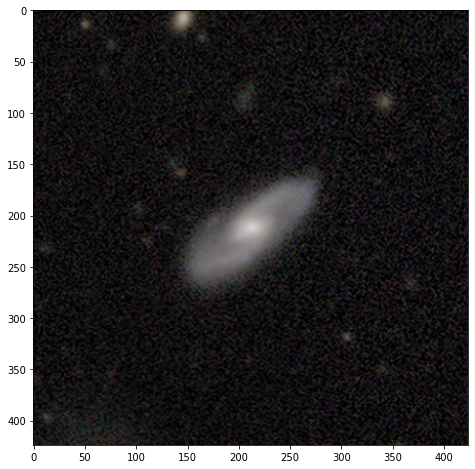

In [14]:
inx = 2000 # random!
file_loc, comp = vp.one_comparison(inx)
display(comp)
img = mpimg.imread(file_loc)
fig = plt.figure(figsize=(8,8))
imgplot = plt.imshow(img)

## Get data for entire test set

In [15]:
%%time
questions = [q for q in decals_pairs]
answers = list(vp.results.columns)[1:]
counts = pd.DataFrame(np.zeros((34, 34), dtype='uint16'), index=answers, columns=answers)

for n in range(vp.results.shape[0]): 
    _, comp = vp.one_comparison(n)
    pair = list(comp[['pred', 'obs']].itertuples(index=False, name=None))
    for i in range(len(questions)):
        pred = '_'.join([questions[i], pair[i][0]])
        vol = '_'.join([questions[i], pair[i][1]])
        counts[pred][vol] += 1

CPU times: user 4min 12s, sys: 38.1 ms, total: 4min 12s
Wall time: 4min 11s


In [16]:
counts

,smooth-or-featured_smooth,smooth-or-featured_featured-or-disk,smooth-or-featured_artifact,disk-edge-on_yes,disk-edge-on_no,has-spiral-arms_yes,has-spiral-arms_no,bar_strong,bar_weak,bar_no,...,spiral-arm-count_1,spiral-arm-count_2,spiral-arm-count_3,spiral-arm-count_4,spiral-arm-count_more-than-4,spiral-arm-count_cant-tell,merging_none,merging_minor-disturbance,merging_major-disturbance,merging_merger
smooth-or-featured_smooth,27411,2183,159,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
smooth-or-featured_featured-or-disk,2365,10356,95,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
smooth-or-featured_artifact,329,54,321,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
disk-edge-on_yes,0,0,0,6481,11265,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
disk-edge-on_no,0,0,0,761,24766,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
has-spiral-arms_yes,0,0,0,0,0,10022,16716,0,0,0,...,0,0,0,0,0,0,0,0,0,0
has-spiral-arms_no,0,0,0,0,0,1279,15256,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bar_strong,0,0,0,0,0,0,0,1047,447,15668,...,0,0,0,0,0,0,0,0,0,0
bar_weak,0,0,0,0,0,0,0,314,936,3795,...,0,0,0,0,0,0,0,0,0,0
bar_no,0,0,0,0,0,0,0,99,287,20680,...,0,0,0,0,0,0,0,0,0,0


In [17]:
counts.to_csv(dataroot / 'results/predictions/decals_confusion.csv')

### Normalize, crudely. 

Note that not all questions ae asked in every case, so using a common denominator just gives a lower bound to the probability

In [18]:
fracs = counts / vp.results.shape[0]
fracs

,smooth-or-featured_smooth,smooth-or-featured_featured-or-disk,smooth-or-featured_artifact,disk-edge-on_yes,disk-edge-on_no,has-spiral-arms_yes,has-spiral-arms_no,bar_strong,bar_weak,bar_no,...,spiral-arm-count_1,spiral-arm-count_2,spiral-arm-count_3,spiral-arm-count_4,spiral-arm-count_more-than-4,spiral-arm-count_cant-tell,merging_none,merging_minor-disturbance,merging_major-disturbance,merging_merger
smooth-or-featured_smooth,0.633443,0.050447,0.003674,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
smooth-or-featured_featured-or-disk,0.054653,0.239318,0.002195,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
smooth-or-featured_artifact,0.007603,0.001248,0.007418,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
disk-edge-on_yes,0.000000,0.000000,0.000000,0.149770,0.260324,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
disk-edge-on_no,0.000000,0.000000,0.000000,0.017586,0.572320,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
has-spiral-arms_yes,0.000000,0.000000,0.000000,0.000000,0.000000,0.231599,0.386292,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
has-spiral-arms_no,0.000000,0.000000,0.000000,0.000000,0.000000,0.029557,0.352552,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
bar_strong,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024195,0.010330,0.362073,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
bar_weak,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007256,0.021630,0.087699,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
bar_no,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002288,0.006632,0.477896,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Get most-likely galaxies for a specific criterion

In [34]:
mergers = vp.top_n('merging_merger', 4)
locs = [Path(loc) for loc in list(mergers['file_loc'])]
names = [loc.stem for loc in locs]
imgs = [mpimg.imread(loc) for loc in locs]

([PosixPath('/home/colin/data/munch1tb/zoobot_data/gz_decals_dr5_png/J114/J114411.65+102156.0.png'),
  PosixPath('/home/colin/data/munch1tb/zoobot_data/gz_decals_dr5_png/J020/J020356.65-055234.6.png'),
  PosixPath('/home/colin/data/munch1tb/zoobot_data/gz_decals_dr5_png/J014/J014852.65-080841.1.png'),
  PosixPath('/home/colin/data/munch1tb/zoobot_data/gz_decals_dr5_png/J084/J084846.98+141729.7.png')],
 ['J114411.65+102156.0',
  'J020356.65-055234.6',
  'J014852.65-080841.1',
  'J084846.98+141729.7'])

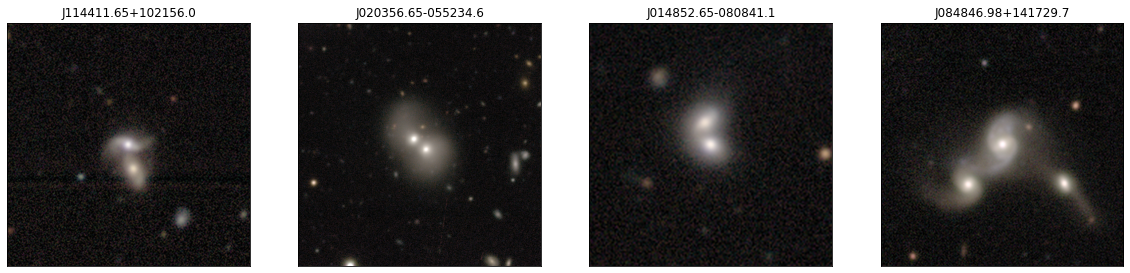

In [47]:
fig, axs = plt.subplots(1, 4, figsize=(20, 10))
for i in range(4):
    axs[i].imshow(imgs[i])
    axs[i].set_title(names[i])
    axs[i].tick_params(left = False,labelleft = False,
                           labelbottom = False, bottom = False);


In [62]:
fig_dir = Path(params['coderoot']) / 'project_report/figures'

def plot_n(colname, n=4):
    mergers = vp.top_n(colname, n)
    locs = [Path(loc) for loc in list(mergers['file_loc'])]
    names = [loc.stem for loc in locs]
    imgs = [mpimg.imread(loc) for loc in locs]
    
    fig, axs = plt.subplots(1, n, figsize=(20, 10))
    for i in range(n):
        axs[i].imshow(imgs[i])
        axs[i].set_title(names[i])
        axs[i].tick_params(left = False,labelleft = False,
                               labelbottom = False, bottom = False)
        
    plt.savefig(fig_dir / f"{colname}_{n}.pdf")
        

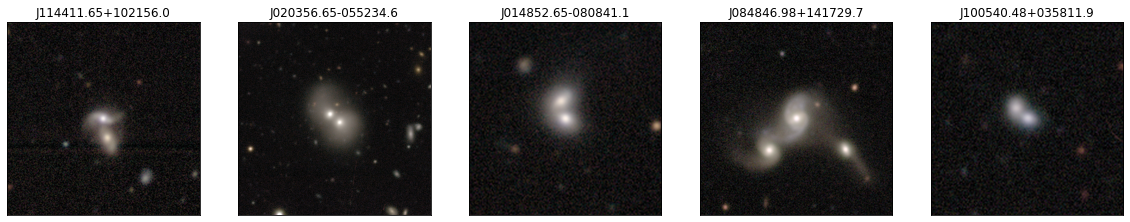

In [63]:
plot_n('merging_merger', 5)

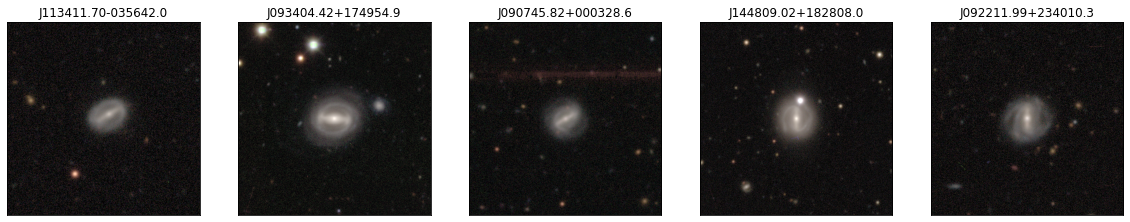

In [64]:
plot_n('bar_strong', 5)

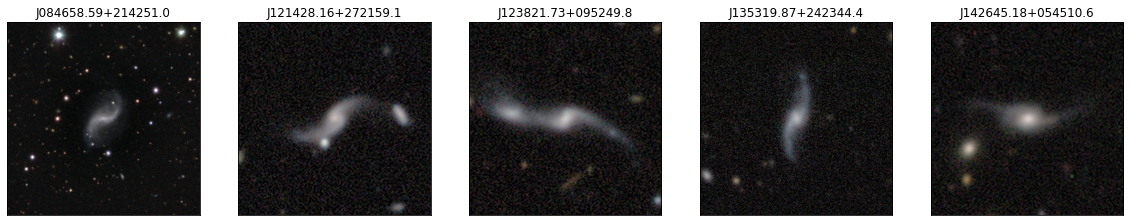

In [65]:
plot_n('spiral-winding_loose', 5)